In [1]:
import sys
sys.path.append('/home/mehdi/github/LSSutils')
sys.path.append('/home/mehdi/github/sysnetdev')
import os
import fitsio as ft
import numpy as np
import pandas as pd
from time import time
from lssutils.lab import hpixsum, to_numpy, make_overdensity

In [2]:
target = 'LRG'
region = 'NBMZLS'

nside = 256
version = 'v1'
root_path = '/home/mehdi/data/'
dat_path = f'{root_path}dr9v0.57.0/sv3_{version}/sv3target_{target}_{region}.fits'
ran_path = f'{root_path}dr9v0.57.0/sv3_{version}/{region}_randoms-1-0x5.fits'
tem_path = f'{root_path}templates/dr9/pixweight_dark_dr9m_nside{nside}.h5'
tab_path = f'{root_path}dr9v0.57.0/sv3nn_{version}/tables/sv3tab_{target}_{region}_{nside}.fits'


t0 = time()
dat = ft.read(dat_path, columns=['RA', 'DEC'])
ran = ft.read(ran_path, columns=['RA', 'DEC'])
t1 = time()
print(f'Read the input catalogs in {t1-t0:.1f} secs')

dathp = hpixsum(nside, dat['RA'], dat['DEC'])*1.0
ranhp = hpixsum(nside, ran['RA'], ran['DEC'])*1.0
t2 = time()
print(f'Project data and randoms to hp in {t2-t1:.1f} secs')

mask = ranhp > 0.0
#columns = ['nstar', 'ebv', 'loghi']\
#          +[f'{s}_{b}' for s in ['ccdskymag_mean', 'fwhm_mean', 'fwhm_min', 'fwhm_max', 'depth_total', 
#                                'mjd_mean', 'mjd_min', 'mjd_max', 'airmass_mean', 'exptime_total']\
#                      for b in ['g', 'r', 'z']]
columns = ['stardens', 'ebv', 'loghi',
           'psfdepth_g', 'psfdepth_r', 'psfdepth_z',
           'galdepth_g', 'galdepth_r', 'galdepth_z', 
           'psfsize_g', 'psfsize_r', 'psfsize_z', 
           'psfdepth_w1', 'psfdepth_w2']
tmpl = pd.read_hdf(tem_path)
tmpl_np = tmpl[columns].values

t3 = time()
print(f'Read imaging maps in {t3-t2:.1f} secs')

mask_t = mask.copy()
for i in range(tmpl_np.shape[1]):
    mask_t &= np.isfinite(tmpl_np[:, i])
print(f'before: {mask.sum()}, after: {mask_t.sum()}')

for i, col in enumerate(columns):
    print(f'{col:10s}: {np.percentile(tmpl_np[mask_t, i], [0, 1, 99, 100])}')

frac = np.zeros_like(ranhp)
frac[mask_t] = ranhp[mask_t] / ranhp[mask_t].mean()
t4 = time()
print(f'Compute pixel completeness in {t4-t3:.1f} secs')


d = to_numpy(dathp[mask_t], tmpl_np[mask_t], 
             frac[mask_t], np.argwhere(mask_t).flatten())

Read the input catalogs in 23.3 secs
Project data and randoms to hp in 8.4 secs
Read imaging maps in 1.3 secs
before: 99301, after: 97581
stardens  : [   76.2545929    228.76376343  3431.45703125 16413.80078125]
ebv       : [0.00361554 0.00703907 0.15274281 0.41871175]
loghi     : [19.6889075  19.86351587 21.11394136 21.24249387]
psfdepth_g: [21.27593422 23.79626389 24.49247093 25.03708839]
psfdepth_r: [21.26277924 23.21738472 23.96852798 24.54239273]
psfdepth_z: [20.34397507 22.92396088 23.73185616 24.03788185]
galdepth_g: [21.19980621 23.64172859 24.3039753  24.78623962]
galdepth_r: [21.14349365 23.04561005 23.73804207 24.26550293]
galdepth_z: [20.17395973 22.64774933 23.34222412 23.60626984]
psfsize_g : [0.5588913  1.47349629 2.4905036  3.3285985 ]
psfsize_r : [0.67107898 1.27846949 2.32693267 2.96838307]
psfsize_z : [0.1035221  0.96962074 1.65969086 2.69280601]
psfdepth_w1: [20.80591583 21.32223206 22.03256569 22.22574615]
psfdepth_w2: [20.47448349 20.67786713 21.70823898 22.151161

In [3]:
import healpy as hp

In [9]:
frac[mask_t].min()

0.04601189821481511

In [10]:
delta = make_overdensity(dathp, frac, mask_t)

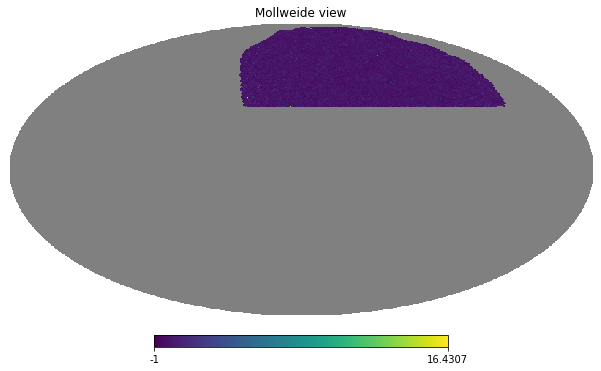

In [12]:
hp.mollview(delta, rot=-120)

In [14]:
import matplotlib.pyplot as plt

(array([9.5275e+04, 2.1330e+03, 1.4200e+02, 2.0000e+01, 4.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-1.        ,  0.74307005,  2.48614011,  4.22921016,  5.97228021,
         7.71535027,  9.45842032, 11.20149037, 12.94456043, 14.68763048,
        16.43070053]),
 <a list of 10 Patch objects>)

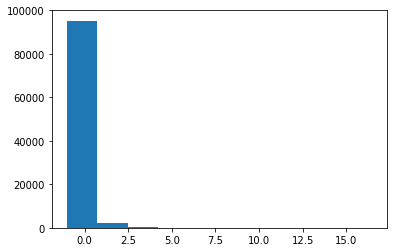

In [15]:
plt.hist(delta[mask_t])

In [37]:
dathp128 = hpixsum(128, dat['RA'], dat['DEC'])*1.0

In [38]:
ranhp128 = hpixsum(128, ran['RA'], ran['DEC'])*1.0

In [26]:
dold = ft.read('/home/mehdi/github/dr9/results/dr9m_lrg_N.fits')

In [34]:
from lssutils.dataviz import setup_color

In [35]:
setup_color()

Text(0.5, 0, 'Ngal')

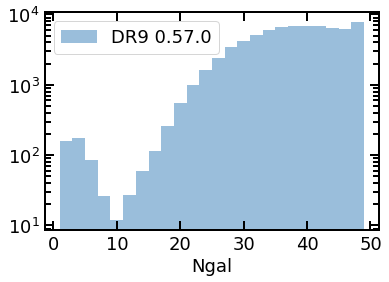

In [52]:
kw = dict(alpha=0.5, bins=np.arange(1.0, 50., 2.0))
plt.hist(d['label'], **kw)
# plt.hist(dold['label'], **kw)
# plt.hist(dathp128[ranhp128 > 0.0], **kw)
plt.legend(['DR9 0.57.0', 'DR9 0.42.0'])
plt.yscale('log')
plt.xlabel('Ngal')

Text(0, 0.5, 'Nlrg')

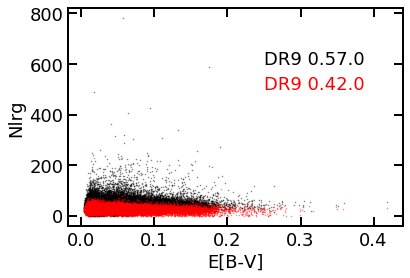

In [45]:
plt.scatter(d['features'][:, 1], d['label'], 1. , marker='.', color='k', alpha=0.5)
plt.scatter(dold['features'][:, 1], dold['label'], 1. , marker='.', color='r', alpha=0.5)
plt.text(0.25, 600, 'DR9 0.57.0', color='k')
plt.text(0.25, 500, 'DR9 0.42.0', color='r')
plt.xlabel('E[B-V]')
plt.ylabel('Nlrg')

In [28]:
np.percentile(dold['label'], [0, 1, 99, 100]), np.percentile(d['label'], [0, 1, 99, 100])

(array([  0.        ,   8.        ,  48.        , 226.99998474]),
 array([  0.,  19.,  91., 781.]))

In [31]:
np.std(dold['label'])

8.339528123334984

In [32]:
np.std(d['label'])

15.334611459993301

In [18]:
d

97581

(array([4.9000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 3.9600e+02, 8.9340e+03, 8.1793e+04, 5.9650e+03]),
 array([0.0460119 , 0.15935454, 0.27269718, 0.38603983, 0.49938247,
        0.61272511, 0.72606775, 0.8394104 , 0.95275304, 1.06609568,
        1.17943832]),
 <a list of 10 Patch objects>)

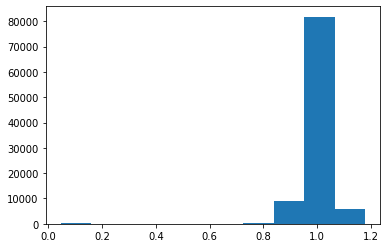

In [17]:
plt.hist(d['fracgood'], bins=)

In [32]:
def read_dr9(target='ELG', region='NBMZLS'):
    nside = 256
    version = 'v1'
    root_path = '/home/mehdi/data/'
    dat_path = f'{root_path}dr9v0.57.0/sv3_{version}/sv3target_{target}_{region}.fits'
    ran_path = f'{root_path}dr9v0.57.0/sv3_{version}/{region}_randoms-1-0x5.fits'
    tem_path = f'{root_path}templates/dr9/pixweight_dark_dr9m_nside{nside}.h5'
    tab_path = f'{root_path}dr9v0.57.0/sv3nn_{version}/tables/sv3tab_{target}_{region}_{nside}.fits'


    t0 = time()
    dat = ft.read(dat_path, columns=['RA', 'DEC'])
    ran = ft.read(ran_path, columns=['RA', 'DEC'])
    t1 = time()
    print(f'Read the input catalogs in {t1-t0:.1f} secs')

    dathp = hpixsum(nside, dat['RA'], dat['DEC'])*1.0
    ranhp = hpixsum(nside, ran['RA'], ran['DEC'])*1.0
    t2 = time()
    print(f'Project data and randoms to hp in {t2-t1:.1f} secs')

    mask = ranhp > 0.0
    frac = np.zeros_like(ranhp)
    frac[mask] = ranhp[mask] / ranhp[mask].mean()
    t3 = time()
    print(f'Compute pixel completeness in {t3-t2:.1f} secs')

    tmpl = pd.read_hdf(tem_path)
    t4 = time()
    print(f'Read imaging maps in {t4-t3:.1f} secs')

    #columns = ['nstar', 'ebv', 'loghi']\
    #          +[f'{s}_{b}' for s in ['ccdskymag_mean', 'fwhm_mean', 'fwhm_min', 'fwhm_max', 'depth_total', 
    #                                'mjd_mean', 'mjd_min', 'mjd_max', 'airmass_mean', 'exptime_total']\
    #                      for b in ['g', 'r', 'z']]
    columns = ['lognstar', 'ebv', 'loghi',
               'psfdepth_g', 'psfdepth_r', 'psfdepth_z',
               'galdepth_g', 'galdepth_r', 'galdepth_z', 
               'psfsize_g', 'psfsize_r', 'psfsize_z', 
               'psfdepth_w1', 'psfdepth_w2']
    tmpl_np = tmpl[columns].values

    mask_t = mask.copy()
    for i in range(tmpl_np.shape[1]):
        mask_t &= np.isfinite(tmpl_np[:, i])
    print(f'before: {mask.sum()}, after: {mask_t.sum()}')
    return dathp, ranhp, mask_t, tmpl_np

In [ ]:
npred = ft.read('/home/mehdi/data/dr9v0.57.0/sv3nn_v1/regression/sv3nn_ELG_NBMZLS_256/nn-weights.fits')

In [33]:
dathp, ranhp, mask, tmpl = read_dr9()

Read the input catalogs in 18.3 secs
Project data and randoms to hp in 8.4 secs
Compute pixel completeness in 0.0 secs
Read imaging maps in 0.5 secs
before: 99301, after: 97581


In [34]:
mask = np.zeros(12*256*256, '?')
mask[npred['hpix']] = True

ngalp = np.zeros(12*256*256)
ngalp[npred['hpix']] = npred['weight'].mean(axis=1)

In [35]:
from lssutils.stats.nnbar import MeanDensity

In [36]:
import pandas as pd

In [38]:
nbar = MeanDensity(dathp, ranhp, mask, tmpl[:, 1])
nbar.run()

nbarp = MeanDensity(ngalp, ranhp, mask, tmpl[:, 1])
nbarp.run()

nbarc = MeanDensity(dathp, ranhp, mask, tmpl[:, 1], selection=2*ngalp)
nbarc.run()

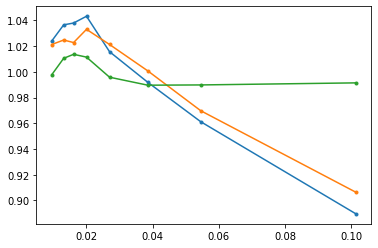

In [45]:
for nbar_i in [nbar, nbarp, nbarc]:
    plt.plot(nbar_i.output['bin_avg'], nbar_i.output['nnbar'], marker='.')